<a href="https://colab.research.google.com/github/Summeryuqing01/Neural-Net-Experiments/blob/main/SimpleDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

**Reporting Functions**


In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

**Preprocess Data**

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

In [ ]:
# encode
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
# reshape
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

In [ ]:
# rescale
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [ ]:
# validation
x_train, x_val = x_train_norm[:55000], x_train_norm[55000:]
y_train_encoded, y_val_encoded = y_train_encoded[:55000], y_train_encoded[55000:]

**Experimment 1**

In [ ]:
model1 = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model1.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history1 = model1.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.1",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6146 - accuracy: 0.3583 - val_loss: 1.5574 - val_accuracy: 0.3566
Epoch 2/200
1719/1719 [==============================] - 10s 6ms/step - loss: 1.6147 - accuracy: 0.3575 - val_loss: 1.5606 - val_accuracy: 0.3572
Epoch 3/200
1719/1719 [==============================] - 8s 5ms/step - loss: 1.6140 - accuracy: 0.3575 - val_loss: 1.5939 - val_accuracy: 0.3306
Epoch 4/200
1719/1719 [==============================] - 4s 3ms/step - loss: 1.6144 - accuracy: 0.3593 - val_loss: 1.5550 - val_accuracy: 0.3762
Epoch 5/200
1719/1719 [==============================] - 4s 3ms/step - loss: 1.6134 - accuracy: 0.3616 - val_loss: 1.5605 - val_accuracy: 0.3552
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 1.6132 - accuracy: 0.3612 - val_loss: 1.5634 - val_accuracy: 0.3504


In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 4s 2ms/step


(60000, 1)

In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.188  0.0411 0.0148 0.1536 0.0099 0.1778 0.1895 0.0126 0.2088 0.0041]
The sum of the probabilities is (approximately) 0.9999999403953552


In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]
activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.00,0.000,4.000,1.000,9.0,2.000,1.000,3.000,1.000,4.0,3.000,5.000,3.000,6.000,1.000
act_val_0,1.94,0.952,0.827,3.686,0.0,2.554,4.087,2.514,3.775,0.0,2.923,2.888,3.741,2.014,4.129


<ipython-input-72-ed66a45a3518>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.boxplot(y='act_val_0', x='actual_class',


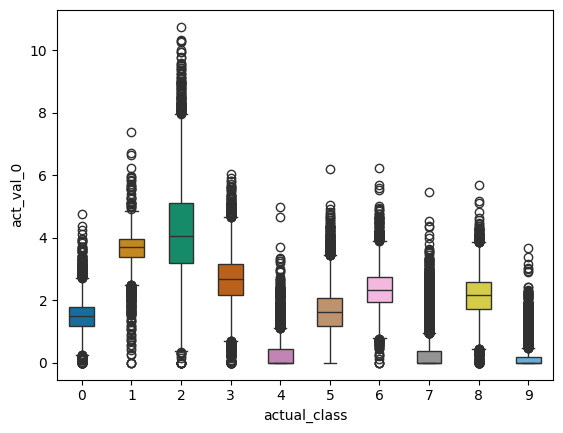

In [ ]:
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

**Experiment 2**

In [ ]:
model2 = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model2.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history2 = model2.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.2",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6942 - accuracy: 0.3346 - val_loss: 1.3551 - val_accuracy: 0.4942
Epoch 2/200
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3166 - accuracy: 0.5365 - val_loss: 1.1679 - val_accuracy: 0.6264
Epoch 3/200
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2019 - accuracy: 0.5997 - val_loss: 1.0865 - val_accuracy: 0.6416
Epoch 4/200
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1472 - accuracy: 0.6157 - val_loss: 1.0597 - val_accuracy: 0.6400
Epoch 5/200
1719/1719 [==============================] - 10s 6ms/step - loss: 1.1195 - accuracy: 0.6215 - val_loss: 1.0304 - val_accuracy: 0.6506
Epoch 6/200
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1024 - accuracy: 0.6284 - val_loss: 1.0137 - val_accuracy: 0.6598
Epoch 7/200
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0902 - accuracy: 0.6324 - val_loss: 1.0037 - val_a

Exception ignored in: <function _xla_gc_callback at 0x7daaf9ef9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1719/1719 [==============================] - 2s 1ms/step


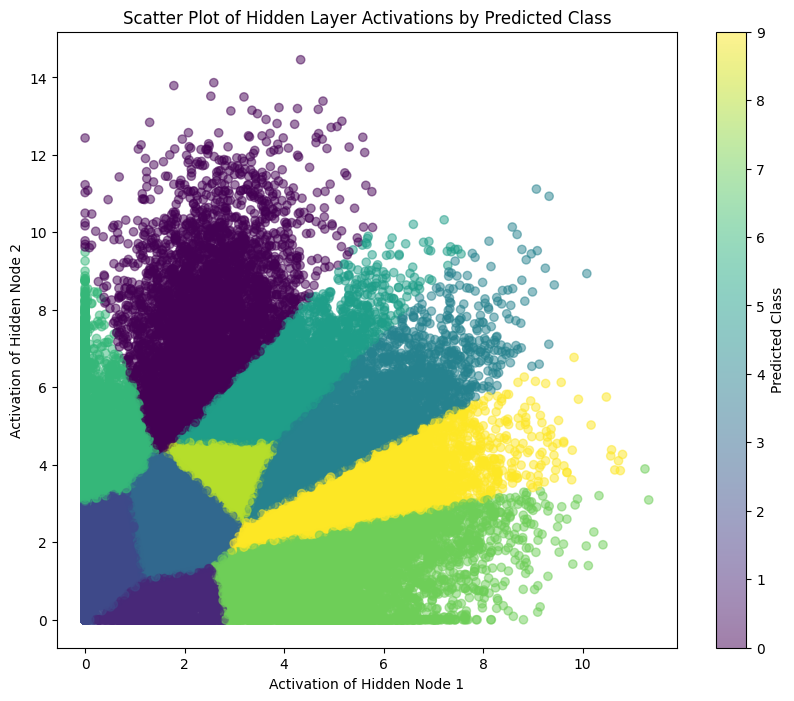

In [ ]:
# Extract activations for the hidden layer
activation_model2 = tf.keras.models.Model(inputs=model2.input,
                                              outputs=model2.layers[0].output)
hidden_activations2 = activation_model2.predict(x_train)

# Predict classes to color-code in the scatter plot
predicted_classes2 = model2.predict(x_train).argmax(axis=1)

# Scatter plot of the two hidden node activations
plt.figure(figsize=(10, 8))
plt.scatter(hidden_activations2[:, 0], hidden_activations2[:, 1], c=predicted_classes2, cmap='viridis', alpha=0.5)
plt.title('Scatter Plot of Hidden Layer Activations by Predicted Class')
plt.xlabel('Activation of Hidden Node 1')
plt.ylabel('Activation of Hidden Node 2')
plt.colorbar(label='Predicted Class')
plt.show()

**Experiment 3**

In [ ]:
model3 = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model3.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history3 = model3.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.3",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3960 - accuracy: 0.9164 - val_loss: 0.2284 - val_accuracy: 0.9574
Epoch 2/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2326 - accuracy: 0.9525 - val_loss: 0.1831 - val_accuracy: 0.9672
Epoch 3/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1955 - accuracy: 0.9609 - val_loss: 0.1578 - val_accuracy: 0.9698
Epoch 4/200
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1781 - accuracy: 0.9645 - val_loss: 0.1552 - val_accuracy: 0.9726
Epoch 5/200
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1674 - accuracy: 0.9663 - val_loss: 0.1497 - val_accuracy: 0.9710
Epoch 6/200
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1625 - accuracy: 0.9675 - val_loss: 0.1468 - val_accuracy: 0.9742
Epoch 7/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1558 - accuracy: 0.9689 - val_loss: 0.1471 - val_a

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.1")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.6042 - accuracy: 0.3843
Test acc: 0.384


In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.2")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.0045 - accuracy: 0.6787
Test acc: 0.679


In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.3")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1503 - accuracy: 0.9716
Test acc: 0.972


**Experiment 4**

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on the training data
pca = PCA(n_components=0.95)
x_train_reduced = pca.fit_transform(x_train.reshape(-1, 784))  # Reshape to 2D array for PCA
x_test_reduced = pca.transform(x_test.reshape(-1, 784))

print(f"Reduced training data shape: {x_train_reduced.shape}")

Reduced training data shape: (55000, 154)


In [ ]:
model4 = Sequential([
    Dense(input_shape=[154], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model4.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history4 = model4.fit(
    x_train_reduced,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.4",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1547/1547 [==============================] - 13s 7ms/step - loss: 0.4207 - accuracy: 0.9121 - val_loss: 0.2533 - val_accuracy: 0.9484
Epoch 2/200
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2022 - accuracy: 0.9595 - val_loss: 0.1975 - val_accuracy: 0.9598
Epoch 3/200
1547/1547 [==============================] - 4s 3ms/step - loss: 0.1628 - accuracy: 0.9689 - val_loss: 0.1715 - val_accuracy: 0.9647
Epoch 4/200
1547/1547 [==============================] - 4s 3ms/step - loss: 0.1426 - accuracy: 0.9735 - val_loss: 0.1572 - val_accuracy: 0.9673
Epoch 5/200
1547/1547 [==============================] - 4s 2ms/step - loss: 0.1302 - accuracy: 0.9763 - val_loss: 0.1479 - val_accuracy: 0.9698
Epoch 6/200
1547/1547 [==============================] - 4s 2ms/step - loss: 0.1201 - accuracy: 0.9786 - val_loss: 0.1469 - val_accuracy: 0.9696
Epoch 7/200
1547/1547 [==============================] - 5s 3ms/step - loss: 0.1128 - accuracy: 0.9800 - val_loss: 0.1368 - val_a

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.4")
print(f"Test acc: {model.evaluate(x_test_reduced, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 17.3136 - accuracy: 0.9619
Test acc: 0.962


**Experiment 5**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier with the training data
rf.fit(x_train_norm, y_train_encoded)

# Get feature importances
importances = rf.feature_importances_

In [ ]:
# Get the indices of the top 70 features
indices = np.argsort(importances)[::-1][:70]

# Select these top features from the training and test data
x_train_reduced_rf = x_train_norm[:, indices]
x_test_reduced_rf = x_test_norm[:, indices]

In [ ]:
model5 = Sequential([
    Dense(input_shape=[70], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model5.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history5 = model5.fit(
    x_train_reduced_rf,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1688/1688 [==============================] - 9s 5ms/step - loss: 0.6976 - accuracy: 0.8210 - val_loss: 0.4593 - val_accuracy: 0.8915
Epoch 2/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4880 - accuracy: 0.8778 - val_loss: 0.3958 - val_accuracy: 0.9045
Epoch 3/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4234 - accuracy: 0.8943 - val_loss: 0.3460 - val_accuracy: 0.9207
Epoch 4/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3852 - accuracy: 0.9037 - val_loss: 0.3465 - val_accuracy: 0.9143
Epoch 5/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3600 - accuracy: 0.9110 - val_loss: 0.3183 - val_accuracy: 0.9245
Epoch 6/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3419 - accuracy: 0.9151 - val_loss: 0.2997 - val_accuracy: 0.9302
Epoch 7/200
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3272 - accuracy: 0.9199 - val_loss: 0.2899 - val_ac

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.5")
print(f"Test acc: {model.evaluate(x_test_reduced_rf, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.2925 - accuracy: 0.9281
Test acc: 0.928
